## Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [1]:
import pandas as pd

# import csv
raw_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Content
It contains the following 6 fields:
1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet
3. date: the date of the tweet
4. flag: The query. If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted
6. text: the text of the tweet

In [2]:
data = raw_data.copy(deep=True)
data['target'] = data['target'].map(lambda x: 1 if x == 4 else 0).astype('bool')
data['ids'] = data['ids'].astype('str')
data['date'] = data['date'].astype('str') # We will convert them to date if useful later, now we just want to reduce the size of the dataframe
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

In [35]:
for col in data.columns:
    print(col, data[col].dtype)
    print(data[col].head())
    print(data[col].value_counts())
    print('\n')

target bool
0    False
1    False
2    False
3    False
4    False
Name: target, dtype: bool
False    800000
True     800000
Name: target, dtype: int64


ids object
0    1467810369
1    1467810672
2    1467810917
3    1467811184
4    1467811193
Name: ids, dtype: object
2190457769    2
1972193428    2
1989776729    2
1989776908    2
1564543229    2
             ..
2197311196    1
2197311146    1
2197310899    1
2197310477    1
2193602129    1
Name: ids, Length: 1598315, dtype: int64


date object
0    Mon Apr 06 22:19:45 PDT 2009
1    Mon Apr 06 22:19:49 PDT 2009
2    Mon Apr 06 22:19:53 PDT 2009
3    Mon Apr 06 22:19:57 PDT 2009
4    Mon Apr 06 22:19:57 PDT 2009
Name: date, dtype: object
Mon Jun 15 12:53:14 PDT 2009    20
Fri May 29 13:40:04 PDT 2009    17
Fri May 22 05:10:17 PDT 2009    17
Mon Jun 15 13:39:50 PDT 2009    17
Fri Jun 05 14:13:07 PDT 2009    16
                                ..
Sun Jun 07 12:36:07 PDT 2009     1
Sun Jun 07 12:36:04 PDT 2009     1
Sun Jun 07 12:36:03 PDT

In order to do a regression on the text, we need to clean those tweets.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = data['text']
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)
Y = data['target']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression(penalty="elasticnet", solver='saga', max_iter=1000, l1_ratio=0.1)
start = time.time()
model.fit(X_train, Y_train)
end = time.time()
print("Training time:", end - start, 's')
Y_pred = model.predict(X_test)

Training time: 227.71447253227234


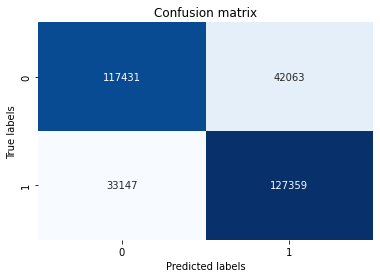

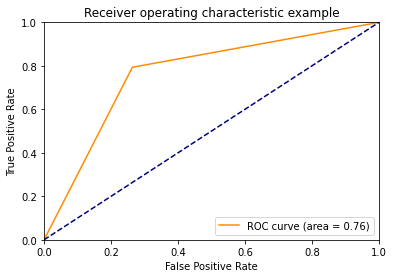

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix




cnf_matrix = confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix')
plt.gcf().set_facecolor('white')
plt.show()

roc = roc_curve(Y_test, Y_pred)
roc_auc = auc(roc[0], roc[1])

plt.figure()
plt.plot(roc[0], roc[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.gcf().set_facecolor('white')
plt.show()

Let's analyse what are the decisive weights/words.

In [33]:
import numpy as np

# Getting the index of the 10 best coefs
ind = np.argpartition(model.coef_[0], -10)[-10:]
sorted_ind = np.flip(ind[np.argsort(model.coef_[0][ind])])
vectorizer_features = vectorizer.get_feature_names_out()
important_words = [vectorizer_features[word_coef] for word_coef in sorted_ind]
print(important_words)

# Same for the words that are the most decisive for negative tweets
ind = np.argpartition(model.coef_[0], -10)[:10]
sorted_ind = np.flip(ind[np.argsort(model.coef_[0][ind])])
vectorizer_features = vectorizer.get_feature_names_out()
important_words = [vectorizer_features[word_coef] for word_coef in sorted_ind]
print(important_words)

['smile', 'welcome', 'followfriday', 'proud', 'congrats', 'thanks', 'thank', 'thx', 'worry', 'loving']
['2nd', 'year', 'yet', 'yesterday', '30', '2day', 'wrong', 'lose', 'leaving', 'wtf']
